## Teeth Classification

## Imports

In [26]:
%pip install tensorflow

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from scipy.ndimage import sobel
from sklearn.manifold import TSNE
import torch
import torchvision.models as models
from torchvision import transforms
import os
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load Data

In [4]:
data_dir = r'C:\Users\Rowan\Downloads\Teeth_Dataset'  
img_height, img_width = 224, 224
batch_size = 32

train_dir = os.path.join(data_dir, 'Training')
val_dir = os.path.join(data_dir, 'Validation')
test_dir = os.path.join(data_dir, 'Testing') 

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


## Preprocessing

* Prepare dental images for analysis through normalization, augmentation.

In [6]:
# Normalization layer
normalizer = layers.Rescaling(1./255)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1), 
    layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))  
])



In [8]:
# Apply normalization to datasets 
def preprocess(image, label):
    image = normalizer(image)
    return image, label


train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [11]:
# Cache and Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

* Cache → keeps data in memory for speed.
* Shuffle(1000) → randomizes training samples for better generalization.
* Prefetch → overlaps data loading with training so GPU isn’t idle.

## Visualization (Distribution)

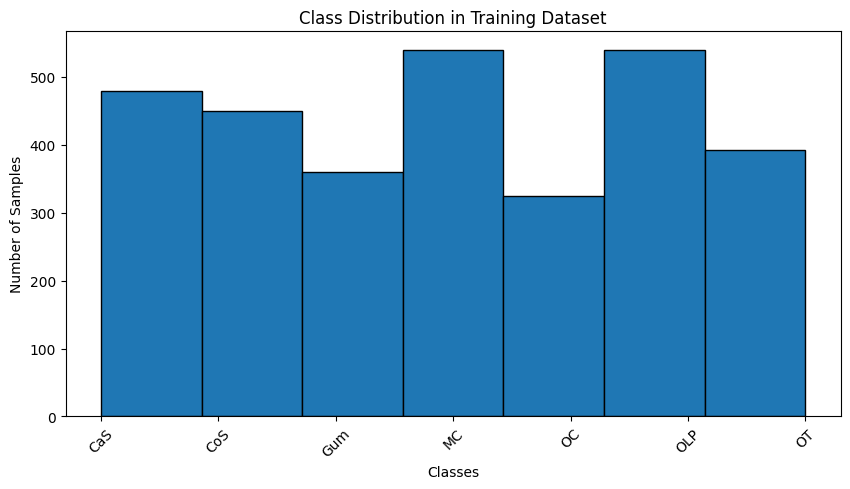

In [12]:
labels = []
for _, lbls in train_dataset:
    labels.extend(lbls.numpy())

plt.figure(figsize=(10, 5))
plt.hist(labels, bins=len(class_names), edgecolor='black')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

* MC and OC have the highest number of samples while OC and Gum have the lower number of samples but the training data is reasonably balanced

## Visualization (Before and After Augmentation)

In [13]:
output_base_dir = 'visualization_outputs'
os.makedirs(output_base_dir, exist_ok=True)
aug_dir = os.path.join(output_base_dir, 'augmentation_visualization')
os.makedirs(aug_dir, exist_ok=True)

count = 0
max_images = 500  # Limit to 500 images for practicality
for images, labels_batch in train_dataset.take(10):  # Process 10 batches (~320 images)
    for i, (image, lbl) in enumerate(zip(images, labels_batch)):
        if count >= max_images:
            break
        cls = class_names[lbl]
        fig = plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f'Original: {cls}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))[0]
        plt.imshow(augmented_image)
        plt.title(f'Augmented: {cls}')
        plt.axis('off')
        filename = os.path.join(aug_dir, f'{cls}_{count:03d}.png')
        plt.savefig(filename)
        plt.close(fig)
        count += 1
    if count >= max_images:
        break
print(f"Augmentation visualizations saved to {aug_dir}")


Augmentation visualizations saved to visualization_outputs\augmentation_visualization


## Histogram of Pixel Intensities (per channel)

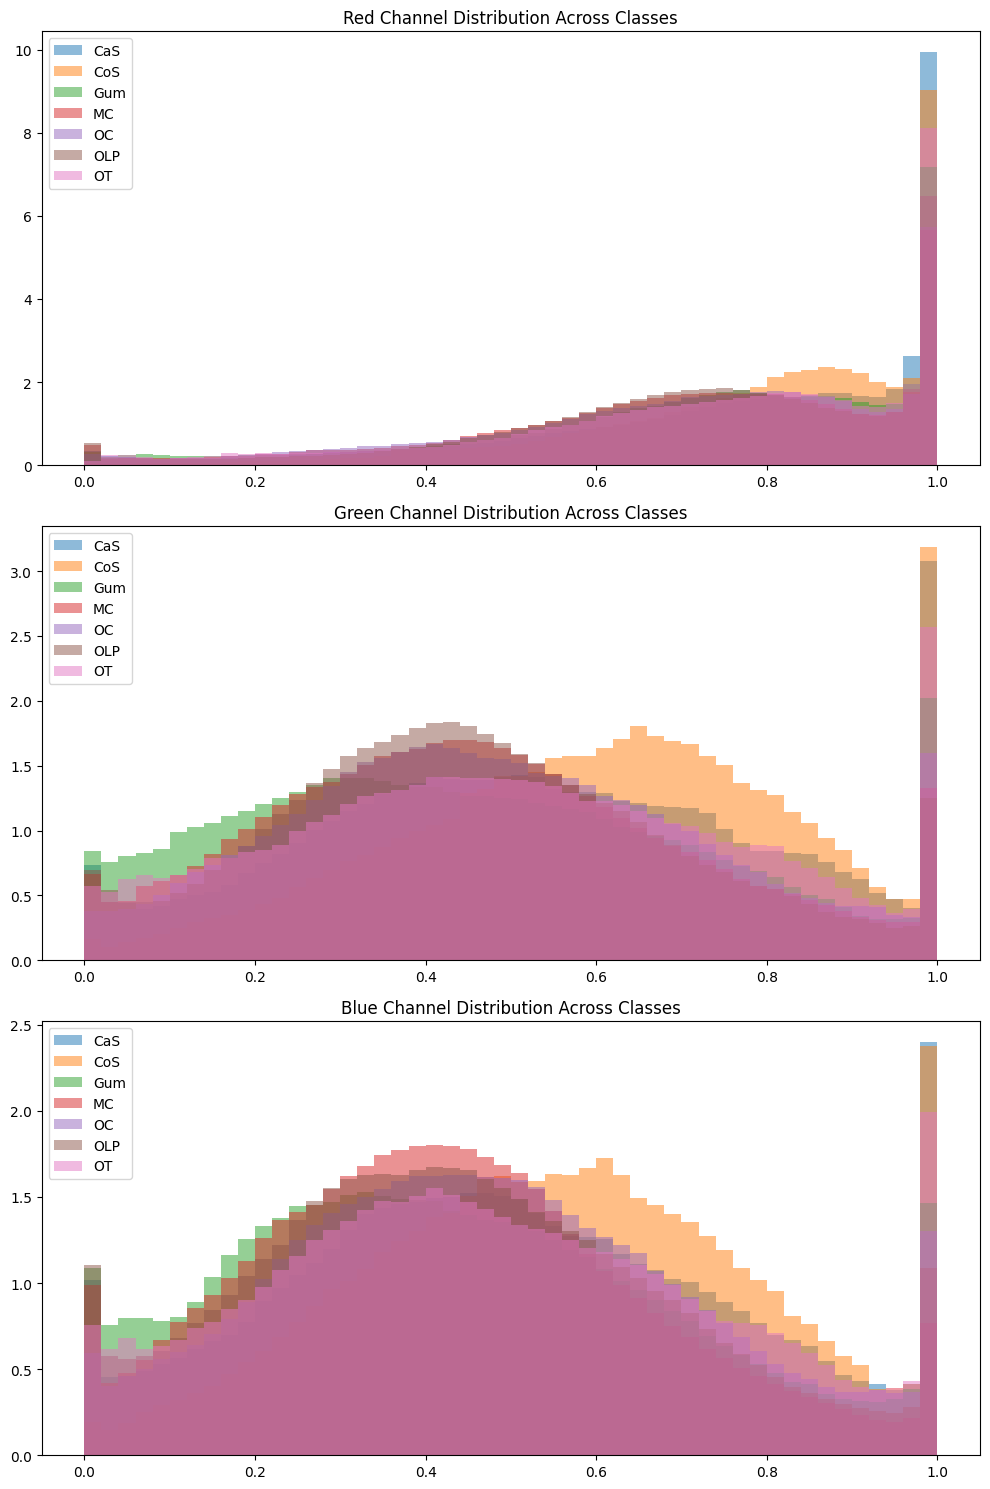

In [14]:
pixel_data = {cls: [] for cls in class_names}

for images, labels_batch in train_dataset.take(100):  
    for img, lbl in zip(images, labels_batch):
        cls = class_names[lbl]
        pixel_data[cls].append(img.numpy()) 

# Plot histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  
channels = ['Red', 'Green', 'Blue']
for ch in range(3):
    for cls in class_names:
        if pixel_data[cls]:
            intensities = np.concatenate([img[..., ch].flatten() for img in pixel_data[cls]])
            axs[ch].hist(intensities, bins=50, alpha=0.5, label=cls, density=True)
    axs[ch].set_title(f'{channels[ch]} Channel Distribution Across Classes')
    axs[ch].legend()
plt.tight_layout()
plt.show()

* Red Channel: Skewed toward higher intensities, This suggests red is key for detecting reddish pathologies.
* Green Channel: Bell-shaped, peaking at mid-intensities , Gum shows darker greens, CoS and OLP mid-peaks, and OT brighter. Overlaps indicate potential confusions in greenish tones.
* Blue Channel: Similar to green, with a gentle peak at ~0.3.

## Sobel Edge Maps

* method used to identify edges in an image by detecting areas of rapid intensity changes , highlights boundaries between objects or regions with different brightness levels.

In [15]:
sobel_dir = os.path.join(output_base_dir, 'sobel_edge_maps')
os.makedirs(sobel_dir, exist_ok=True)

count = 0
max_images = 500  
for images, labels_batch in train_dataset:
    for i, (img, lbl) in enumerate(zip(images.numpy(), labels_batch.numpy())):
        if count >= max_images:
            break
        cls = class_names[lbl]
        fig = plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Original: {cls}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        gray = np.mean(img, axis=2)  # Grayscale
        sobel_img = np.hypot(sobel(gray, axis=0), sobel(gray, axis=1))  
        plt.imshow(sobel_img, cmap='gray')
        plt.title(f'Sobel Edges: {cls}')
        plt.axis('off')
        filename = os.path.join(sobel_dir, f'{cls}_{count:03d}.png')
        plt.savefig(filename)
        plt.close(fig)
        count += 1
    if count >= max_images:
        break
print(f"Sobel edge maps saved to {sobel_dir}")

Sobel edge maps saved to visualization_outputs\sobel_edge_maps


## Dimensionality Reduction (t-SNE)

* t-SNE reduces high-dimensional ResNet features to 2D for visualizing class clusters

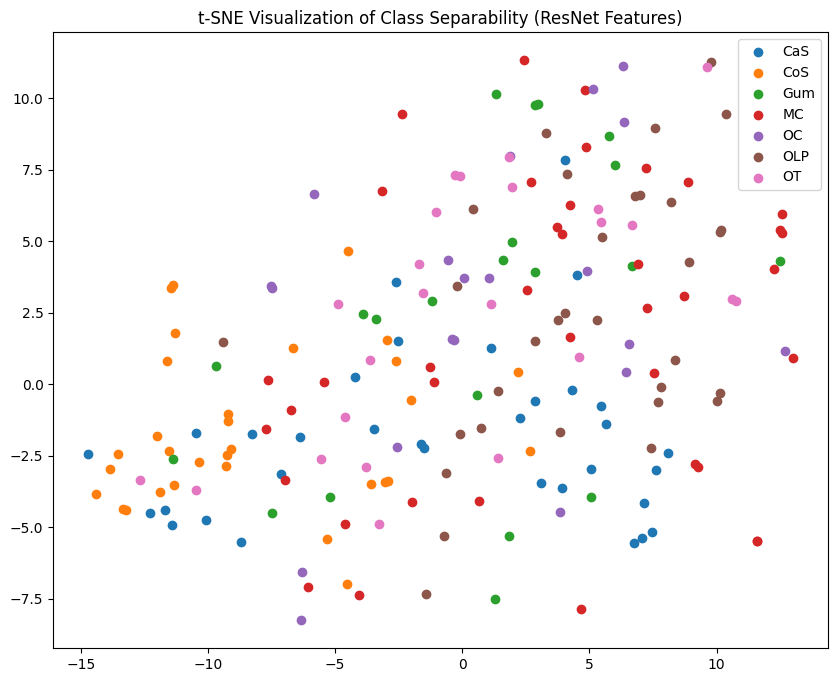

In [16]:
resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
resnet.eval()
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

features = []
labels_list = []
count = 0
max_samples = 200

for images, labels_batch in train_dataset:
    for img, lbl in zip(images, labels_batch):
        if count >= max_samples:
            break
        img_rgb = img[..., :3]
        img_np = (img_rgb.numpy() * 255).astype('uint8')
        img_t = preprocess(img_np)
        with torch.no_grad():
            feat = resnet(img_t.unsqueeze(0)).detach().numpy().flatten()
        features.append(feat)
        labels_list.append(lbl.numpy())
        count += 1
    if count >= max_samples:
        break

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(np.array(features))

# Plot
plt.figure(figsize=(10, 8))
for i, cls in enumerate(class_names):
    idx = np.where(np.array(labels_list) == i)[0]
    if len(idx) > 0:
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=cls)
plt.title('t-SNE Visualization of Class Separability (ResNet Features)')
plt.legend()
plt.show()

* CaS (blue) and CoS (orange) form tight groups on the left/lower side, indicating good separability.

## Modeling (Sequential CNN)

In [17]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

c:\Users\Rowan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (1, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (1, 224, 224, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 224, 224, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 112, 112, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 112, 112, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 112, 112, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (1, 56, 56, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 56, 56, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 56, 56, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (1, 28, 28, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 28, 28, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (1, 28, 28, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (1, 14, 14, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 14, 14, 512)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (1, 14, 14, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (1, 7, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (1, 7, 7, 512)         │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (1, 7, 7, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (1, 3, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (1, 512)               │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 256)               │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,099,527 (15.64 MB)

 Trainable params: 4,096,519 (15.63 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 50

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    CSVLogger('training_log.csv', append=False)
]


# Extract true labels from training dataset
y_train = np.concatenate([y for x, y in train_dataset], axis=0)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)


Class Weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}
Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.2342 - loss: 2.5904 - val_accuracy: 0.1449 - val_loss: 3.6754 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.2974 - loss: 2.2580 - val_accuracy: 0.2519 - val_loss: 2.6470 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3362 - loss: 2.1301 - val_accuracy: 0.2383 - val_loss: 2.9576 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3657 - loss: 2.0459 - val_accuracy: 0.1498 - val_loss: 4.4920 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.3719 - loss: 1.9825 - val_accuracy: 0.3551 - val_loss: 2.0207 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━

## Evaluation (Metrics and Plots)

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.9455 - loss: 0.3395
Test metrics: {'accuracy': 0.9455252885818481, 'loss': 0.3394802510738373}


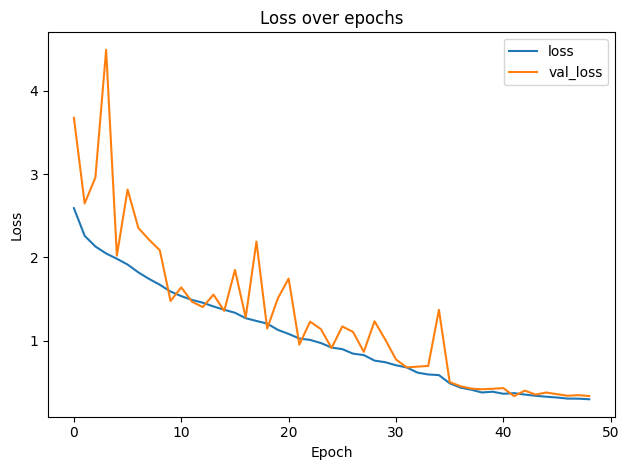

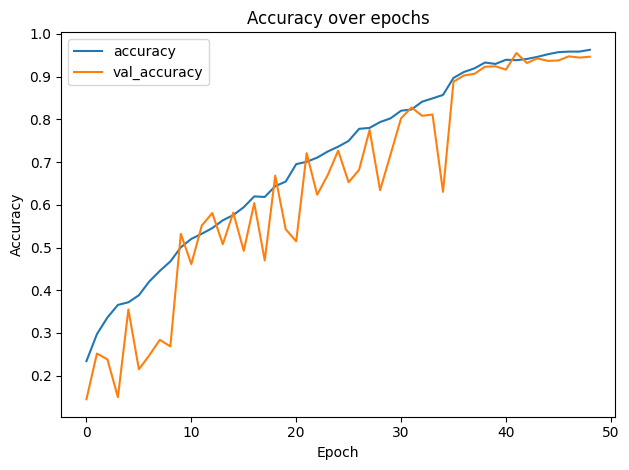

In [23]:

test_metrics = model.evaluate(test_dataset, return_dict=True)
print("Test metrics:", test_metrics)

# Plot training history
def plot_history(hist):
    plt.figure()
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(hist.history['accuracy'], label='accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


## Confusion Matrix

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9455 - loss: 0.3395
Test accuracy: 0.9455252885818481
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352m

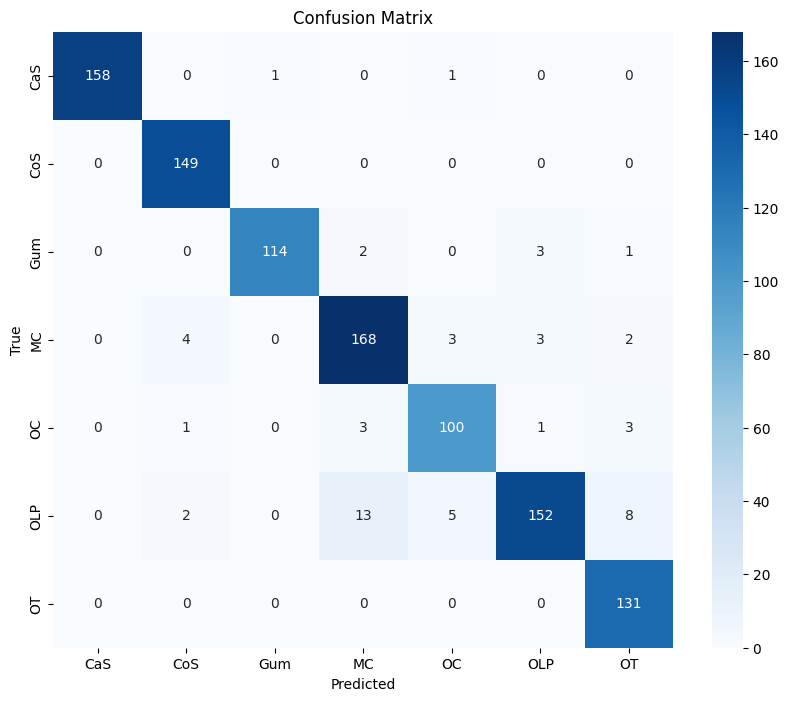

In [24]:
# Evaluate on Test Set and Confusion Matrix
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

# Get predictions
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* The confusion matrix showed most predictions aligned with the correct classes (strong diagonal dominance), meaning the model rarely confused different conditions.

## Classification Report

In [27]:
# Predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step
              precision    recall  f1-score   support

         CaS       1.00      0.99      0.99       160
         CoS       0.96      1.00      0.98       149
         Gum       0.99      0.95      0.97       120
          MC       0.90      0.93      0.92       180
          OC       0.92      0.93      0.92       108
         OLP       0.96      0.84      0.90       180
          OT       0.90      1.00      0.95       131

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



* The classification report confirmed balanced performance across classes